In [2]:

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy

In [3]:

sig_c = 0.05      # bipolar receptive fied size ~ 1/5 of the actual size [mm]
tau1 = 0.04       # excitation time constant of the remporal filter [s]
tau2 = 0.0876     # rebound time constant [s]
bifw = 0.         # relative weight of rebound/excitation [1]
# scale_mV = 1.     # UPDATED 
scale_mV = 20.     # UPDATED 

tauA = 0.15   # time constant of amacrine cells [s]
tauB = 0.08   # time constant of bipolar cells [s]
tauG = 0.01   # time contant of ganglion cells [s]

wAB = 10.     # synaptic weight from bipolar to amacrine [Hz]
wBA = -10.    # synaptic weight from amacrine to bipolar [Hz]
wGB = 4.0     # synaptic weight from bipolar to gangion  [Hz].   #UPDATED
wGA = 0.      # synaptic weight from amacrine  to gangion  [Hz]

slope = 5  # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
threshold = 0 # threshold for ganglion cell recritifation [Hz/mV]

sig_pool = 0.065   # sigma for gaussian pooling in ganlion gells [mm]
spacing = 0.005    # spacing of cells on the lattice [mm]
delta = spacing 
N = 512             # number of neurons in each layer [1]
L =  N * delta #300 * 0.005
idx = int(N/2)

b =  0.160          # half bar width [mm]
speed =  0.8        # speed [mm/s]
dt = 0.001          # integration time step [s]

In [8]:

# load data
name = f'bar_{speed}'
data = np.load(f'../output/Brian/BC_grid_{name}.npy')
stim = np.load(f'../output/Brian/stim_{name}.npy')

In [18]:
ft_signal = np.fft.fft2(signal)


In [22]:
signal.shape,ft_signal.shape

((512, 3199), (512, 3199))

In [35]:

def compute_spatiotemporal_frequencies(signal, dt, delta):

    # # Perform a 2D Fourier Transform on the signal
    ft_signal = np.fft.fft2(signal)

    # # Shift the zero frequency component to the center
    ft_signal= np.fft.fftshift(ft_signal)

    # # Compute the magnitude (for visualization)
    # magnitude_spectrum = np.abs(ft_signal_shifted)
    
    # Get the frequency components along each dimension
    spatial_freqs = np.fft.fftfreq(signal.shape[0], d=dt)
    temporal_freqs = np.fft.fftfreq(signal.shape[1], d = delta)

    # return spatial_freqs, temporal_freqs, magnitude_spectrum
    return spatial_freqs, temporal_freqs, ft_signal



def plot_spatiotemporal_frequencies(spatial_freqs, temporal_freqs, magnitude_spectrum):

    plt.figure(figsize=(8, 6))
    plt.imshow(magnitude_spectrum, extent=(temporal_freqs.min(), temporal_freqs.max(), spatial_freqs.min(), spatial_freqs.max()), aspect='auto')
    plt.plot()
    plt.colorbar(label='Magnitude')
    plt.xlabel('omega')
    plt.ylabel('k')
    plt.title('Spatiotemporal Frequency Spectrum')
    plt.show()


def ghat(omega,k, v, L, s2 = -1):
    return 1j * (np.exp((-1j * (omega-k*v*s2) * (L/v)) -1) /(omega-k*v*s2) )


# def extract_resonance_speed(magnitudes): 
#     N,tps = magnitudes.shape
#     max_idx = magnitudes.argmax()
#     spacemax = max_idx // tps
#     timemax = max_idx % tps
#     return (spacemax*0.005)/(timemax*0.001) #mm/s


In [36]:
signal = data
signal = signal - signal.mean(axis = 0)
N, T = signal.shape

Text(0.0, 1.0, '$V_{B}$')

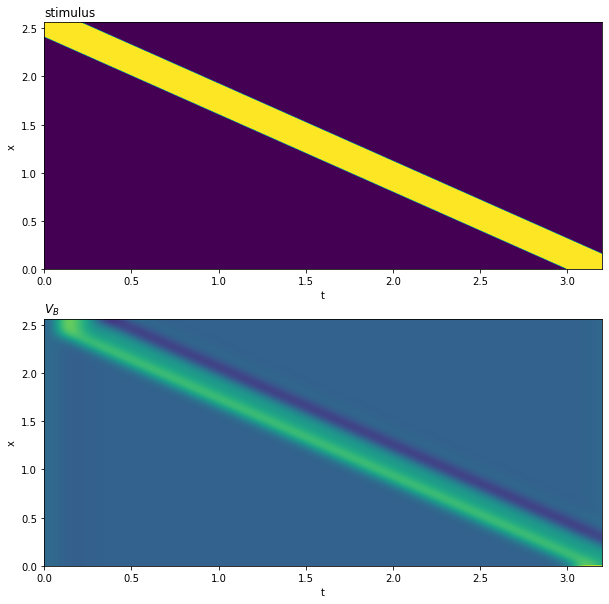

In [37]:
fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(2,1)

ax = fig.add_subplot(gs[0,0])
ax.imshow(stim,extent=(0, T*dt, 0, L), aspect='auto')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('stimulus', loc = 'left')

ax = fig.add_subplot(gs[1,0])
ax.imshow(signal,extent=(0, T*dt, 0, L), aspect='auto')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title(r'$V_{B}$', loc = 'left')


In [38]:

# spatial_freqs, temporal_freqs, magnitude_spectrum = compute_spatiotemporal_frequencies(signal, dt = dt, delta = delta)
spatial_freqs, temporal_freqs, fts = compute_spatiotemporal_frequencies(signal, dt = dt, delta = delta)

omega_range = np.linspace(temporal_freqs.max(), temporal_freqs.min(), len(spatial_freqs))
krange_range = np.linspace(spatial_freqs.max(), spatial_freqs.min(), len(temporal_freqs))


omega_mat = np.zeros((len(spatial_freqs),len(temporal_freqs)))
k_mat = np.zeros((len(spatial_freqs),len(temporal_freqs)))

for row in range(len(krange_range)):
    omega_mat[:,row] = omega_range

for col in range(len(omega_range)):
    k_mat[col,:] = krange_range


ghat_mat  =ghat(omega_mat,k_mat,speed,L)
df = fts/ghat_mat

Text(0.5, 1.0, 'spectrum / g_hat')

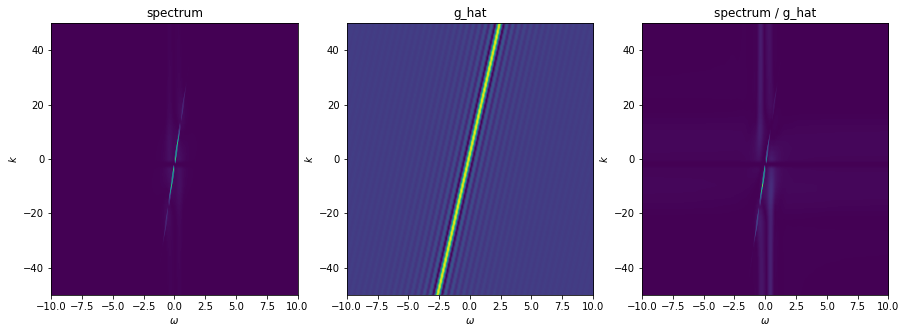

In [41]:
fig = plt.figure(figsize = (15,5))
gs = fig.add_gridspec(1,3)



ax = fig.add_subplot(gs[0,0])
ax.imshow(np.abs(fts),extent=(temporal_freqs.min(), temporal_freqs.max(), spatial_freqs.min(), spatial_freqs.max()), aspect='auto')
ax.set_xlim(-10,10)
ax.set_ylim(-50,50)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('spectrum')

ax = fig.add_subplot(gs[0,1])
ax.imshow(ghat_mat.real,extent=(temporal_freqs.min(), temporal_freqs.max(), spatial_freqs.min(), spatial_freqs.max()), aspect='auto')
ax.set_xlim(-10,10)
ax.set_ylim(-50,50)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('g_hat')


ax = fig.add_subplot(gs[0,2])
ax.imshow(np.abs(df),extent=(temporal_freqs.min(), temporal_freqs.max(), spatial_freqs.min(), spatial_freqs.max()), aspect='auto')
ax.set_xlim(-10,10)
ax.set_ylim(-50,50)

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$k$')

ax.set_title('spectrum / g_hat')


In [ ]:
# match amplitudes ?
# transform into right frequencies ? 